In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# AI Model for Pneumonia Detection Using Chest X-Ray Images
## Table of Contents

* [Imports](#imports)

* [Helper functions](#helper)

* [EDA](#eda)
    * [Dataset contents](#cont)
    * [Number of images](#num)
    * [Sample images](#samp)

* [Data preprocessing](#prep)

* [Models](#models)
     * [Basic model](#basic_model)
         * [Basic Model](#bm_eval)
         * [Basic Model evaluation](#bm_eval)
         * [Fine tune Basic Model](#ft_bm)
         * [Fine tune Basic Model evaluation](#ft_bm_eval)
     * [Transfer learning with DenseNet](#tl_dn)
         * [Basic DenseNet model](#tl_dn)
         * [Basic DenseNet Model evaluation](#dn_eval)
         * [Fine tune DenseNet Model](#ft_dn)
         * [Fine tune DenseNet Model evaluation](#ft_dn_eval)

* [Summary](#summ)

<a id='imports'></a>

## Imports

In [66]:
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

tf.__version__

'2.15.0'

<a id='helper'></a>

## Helper functions

In [28]:
IMG_SIZE = 224
BATCH_SIZE = 16

# Function that show images from dataset
def show_data(image_batch, label_batch, dataset_name):
    plt.figure(figsize=(15, 6))
    plt.suptitle(dataset_name, fontsize=16)
    for n in range(10):
        ax = plt.subplot(2, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# Plot the chart for accuracy and loss on both training and validation
def plot_model_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()

    plt.show()

# Defining parameters for fine-tuning
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping('val_loss', patience=15, restore_best_weights=True)

<a id='eda'></a>

## EDA

<a id='cont'></a>

Let`s see what subdirectories we have

In [29]:
base_dir = './drive/MyDrive/Colab Notebooks/Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/val'))

print("\nContents of test directory:")
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['train', 'val', 'test']

Contents of train directory:
['pneumonia', 'normal']

Contents of validation directory:
['normal', 'pneumonia']

Contents of test directory:
['pneumonia', 'normal']


In [30]:
# Assign each of these directories to a variable so I can use it later
# Directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Directory with training pictures
train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')

# Directory with validation pictures
validation_normal_dir = os.path.join(validation_dir, 'normal')
validation_pneumonia_dir = os.path.join(validation_dir, 'pneumonia')

# Directory with test pictures
test_normal_dir = os.path.join(test_dir, 'normal')
test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')

Now see what the filenames look like in the `normal` and `pneumonia` `train` directories (file naming conventions are the same in the validation directory):

In [20]:
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

print(train_normal_fnames[:10])
print(train_pneumonia_fnames[:10])

['IM-0509-0001-0002.jpeg', 'IM-0524-0001.jpeg', 'IM-0517-0001.jpeg', 'IM-0508-0001.jpeg', 'IM-0510-0001.jpeg', 'IM-0511-0001-0002.jpeg', 'IM-0525-0001-0002.jpeg', 'IM-0523-0001-0001.jpeg', 'IM-0529-0001.jpeg', 'IM-0521-0001.jpeg']
['person51_bacteria_248.jpeg', 'person501_bacteria_2115.jpeg', 'person498_virus_1007.jpeg', 'person531_bacteria_2239.jpeg', 'person502_virus_1011.jpeg', 'person500_bacteria_2107.jpeg', 'person518_bacteria_2200.jpeg', 'person536_bacteria_2259.jpeg', 'person530_virus_1052.jpeg', 'person51_bacteria_246.jpeg']


<a id='num'></a>

Let's find out the total number of `normal` and `pneumonia` images in the `train`, `validation` and `test` directories:

In [21]:
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total training pneumonia images:', len(os.listdir(train_pneumonia_dir) ))

print('total validation normal images:', len(os.listdir(validation_normal_dir)))
print('total validation pneumonia images:', len(os.listdir(validation_pneumonia_dir)))

print('total test normal images:', len(os.listdir(test_normal_dir)))
print('total test pneumonia images:', len(os.listdir(test_pneumonia_dir)))

total training normal images: 1342
total training pneumonia images: 3876
total validation normal images: 8
total validation pneumonia images: 8
total test normal images: 234
total test pneumonia images: 390


<a id='samp'></a>

Take a look at a few pictures to get a better sense of what the `normal` and `pneumonia` datasets look like. First, configure the matplotlib parameters:

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


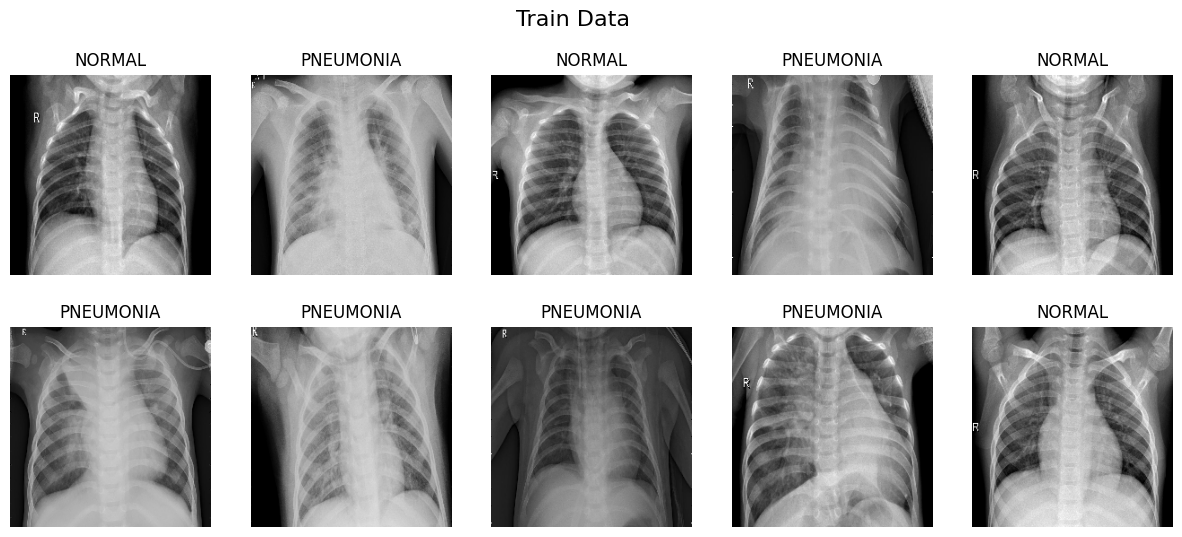

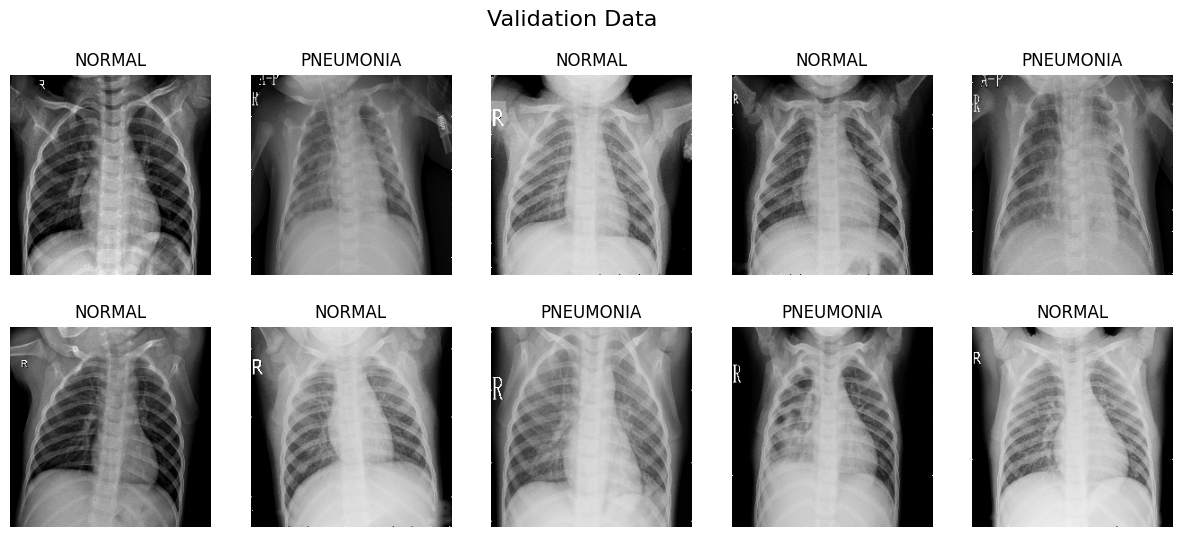

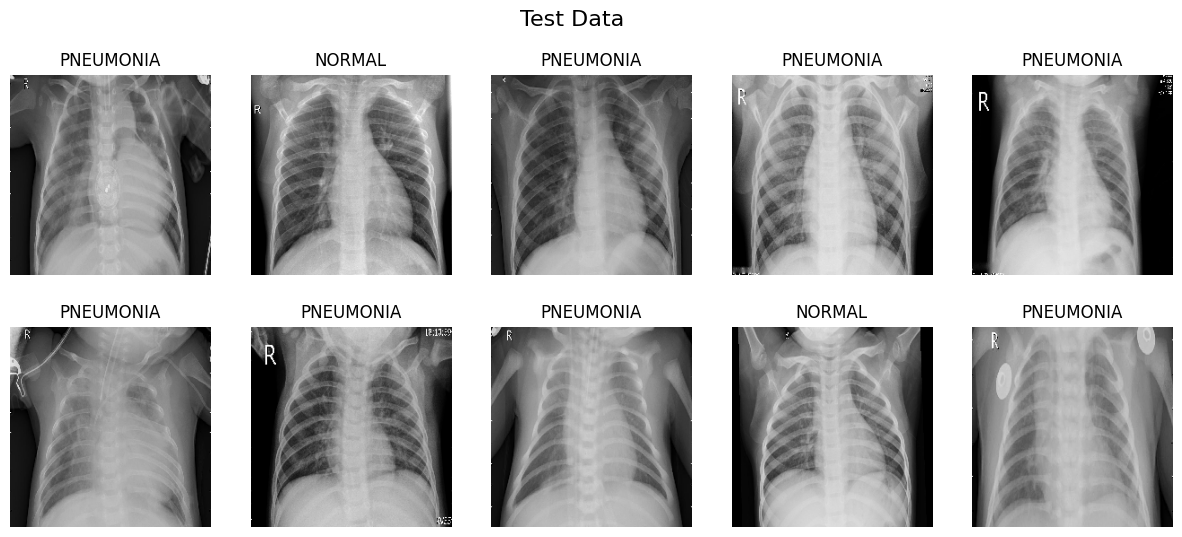

In [22]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
val_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_data = train_datagen.flow_from_directory(train_dir, batch_size=BATCH_SIZE, class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE))
val_data = val_datagen.flow_from_directory(validation_dir, batch_size=BATCH_SIZE, class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE))
test_data = test_datagen.flow_from_directory(test_dir, batch_size=BATCH_SIZE, class_mode='binary', target_size=(IMG_SIZE, IMG_SIZE))

# First you need to run cell from "Data preprocessing"
train_batch, train_batch_label = next(iter(train_data))
show_data(train_batch, train_batch_label,'Train Data')
val_batch, val_batch_label = next(iter(val_data))
show_data(val_batch, val_batch_label,'Validation Data')
test_batch, test_batch_label = next(iter(test_data))
show_data(test_batch, test_batch_label,'Test Data')

<a id='prep'></a>

## Data preprocessing

In [31]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
val_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_data = train_datagen.flow_from_directory(train_dir, batch_size=BATCH_SIZE, interpolation="bilinear",
                                               class_mode='categorical', classes=['normal', 'pneumonia'],
                                               target_size=(IMG_SIZE, IMG_SIZE))
val_data = val_datagen.flow_from_directory(validation_dir, batch_size=BATCH_SIZE, interpolation="bilinear",
                                           class_mode  = 'categorical', classes=['normal', 'pneumonia'],
                                           target_size = (IMG_SIZE, IMG_SIZE))
test_data = test_datagen.flow_from_directory(test_dir, batch_size=BATCH_SIZE, interpolation="bilinear",
                                             class_mode  = 'categorical', classes=['normal', 'pneumonia'],
                                             target_size = (IMG_SIZE, IMG_SIZE))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<a id='models'></a>

## Models
building, tuning, selection

<a id='basic_model'></a>

### Building a Basic Model from Scratch

In [32]:
def build_model():
    model=Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='inputLayer'),

        Conv2D(filters=32, kernel_size=5, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=64, kernel_size=5, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=128, kernel_size=5, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=256, kernel_size=3, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=256, kernel_size=3, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [33]:
basic_model = build_model()
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 batch_normalization_5 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 106, 106, 64)      51264     
                                                                 
 batch_normalization_6 (Bat  (None, 106, 106, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
history_basic_model = basic_model.fit(train_data, validation_data = (val_data), epochs=15)

<a id='bm_eval'></a>

#### Basic Model evaluation

In [ ]:
plot_model_history(history_basic_model)

In [ ]:
basic_model.evaluate(test_data)

<a id='ft_bm'></a>

#### Fine-tune Basic Model

In [ ]:
history_bm_ft = basic_model.fit(train_data, validation_data = val_data, epochs=100, callbacks=[reduce_lr, early_stopping])

<a id='ft_bm_eval'></a>

#### Fine tune Basic Model evaluation

In [ ]:
plot_model_history(history_bm_ft)

In [ ]:
basic_model.evaluate(test_data)

<a id='tl_dn'></a>

### Transfer learning with DenseNet

In [34]:
base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the pretrained weights
base_model.trainable = False

# Augmantation sequence
intput_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
augmantation = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    RandomZoom(0.2)
])
x = augmantation(intput_layer)
# pretrain output
pretrain_out = base_model(x, training = False)

# Rebuild top
x = GlobalAveragePooling2D()(pretrain_out)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)

# Add a dropout rate
x = Dropout(0.4)(x)

# Output layer
outputs = Dense(2, activation='softmax')(x)

# Compile
model_densenet = tf.keras.Model(inputs=intput_layer, outputs=outputs, name="DenseNet201")
model_densenet.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

74836368/74836368 [==============================] - 1s 0us/step


In [35]:
model_densenet.summary()

Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_10 (Ba  (None, 1920)              7680      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 512)               

In [ ]:
history_densenet = model_densenet.fit(train_data, validation_data = val_data, epochs=15)

<a id='dn_eval'></a>

#### Basic DenseNet Model evaluation

In [ ]:
plot_model_history(history_densenet)

In [ ]:
model_densenet.evaluate(test_data)

<a id='ft_dn'></a>

### Fine-tune model based on DenseNet

In [36]:
print(f'Model layers amount: {len(model_densenet.layers)}')

Model layers amount: 8


In [37]:
def unfreeze_model(model, optimizer):
    # We unfreeze all layers, leaving the BatchNorm layers frozen to preserve model knowledge.
    for layer in model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [38]:
optimizer_densenet_ft = Adam(learning_rate=1e-4)
unfreeze_model(model_densenet, optimizer_densenet_ft)

total_params = model_densenet.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model_densenet.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 19,314,242 total parameters in this model.
There are 19,081,346 trainable parameters in this model.


In [39]:
model_densenet.summary()

Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_10 (Ba  (None, 1920)              7680      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 512)               

In [40]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
history_densenet_ft = model_densenet.fit(train_data, validation_data = val_data, epochs=100, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
326/326 [==============================] - 464s 1s/step - loss: 0.2441 - accuracy: 0.8965 - val_loss: 12.4159 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
326/326 [==============================] - 134s 411ms/step - loss: 0.1692 - accuracy: 0.9373 - val_loss: 0.2418 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/100
326/326 [==============================] - 135s 413ms/step - loss: 0.1388 - accuracy: 0.9490 - val_loss: 0.5461 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/100
326/326 [==============================] - 135s 414ms/step - loss: 0.1253 - accuracy: 0.9534 - val_loss: 30.9116 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
326/326 [==============================] - 132s 403ms/step - loss: 0.1138 - accuracy: 0.9597 - val_loss: 3.5091 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/100
326/326 [==============================] - 133s 407ms/step - loss: 0.1028 - accuracy: 0.9630 - val_loss: 0.1113 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 7/100
326/3

<a id='ft_dn_eval'></a>

#### Fine tune DenseNet Model evaluation

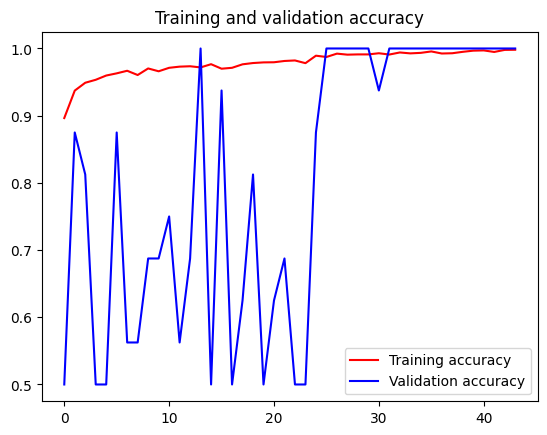

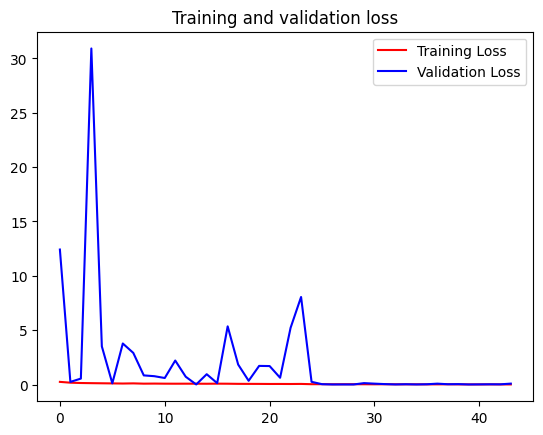

<Figure size 640x480 with 0 Axes>

In [41]:
plot_model_history(history_densenet_ft)

In [42]:
model_densenet.evaluate(test_data)

39/39 [==============================] - 65s 2s/step - loss: 0.6322 - accuracy: 0.9151


[0.6321799159049988, 0.9150640964508057]

In [44]:
# Save model in .keras format
ts = int(time.time())
base_file_path = os.getcwd() + '/drive/MyDrive/Colab Notebooks/'
file_path = base_file_path + str(ts)

model_densenet.save('{}.keras'.format(file_path))

In [54]:
# Save model in saved_model format
!mkdir -p saved_model
model_densenet.save('saved_model/densenet')
!zip -r /content/saved_model.zip /content/saved_model/
from google.colab import files
files.download("/content/saved_model.zip")

In [58]:
# Save model in h5 format
ts = int(time.time())
base_file_path = os.getcwd() + '/drive/MyDrive/Colab Notebooks/'
file_path = base_file_path + str(ts)

model_densenet.save('{}.h5'.format(file_path))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<a id='summ'></a>

## Summary

1. The analysis showed that there are only 16 pictures for validation, which is why such sharp jumps are observed in the `Validation accuracy` and `Validation loss` graphs
2. Basic Model made from scratch shows 0.727 accuracy and 0.796 accuracy after fine tuning
3. Model made with pretrained DenseNet shows 0.889 accuracy and 0.915 accuracy after fine tuning